In [1]:
# Goal: Investigate the arnett peak using the vanilla variation of it
import sys
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numba
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
import astropy.units as u
import astropy.table as table
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import seaborn
import tqdm
try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataset as dataset
import snelib19odp.const as const
import snelib19odp.utils as utils
import snelib19odp.tigerfit as tigerfit
import snelib19odp.analysis.arnett as arnett

In [2]:
%timeit arnett.luminosity_nico(10, 0.2, 10, 3)

5.64 µs ± 92.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [3]:
ds = dataset.load_dataset('SN2019odp_phot')

In [32]:
# Params
texpl_range = (58712.48, 58716.38)
time_range = (ds.transient.prior_t0 - 14, ds.transient.prior_t0+20)
prior_kwargs = {
#    'vej_min': 9477,
#    'vej_max': 12347,
#    'gamma_trapped': True
}
time_valid = np.array([
    [58700, 58880],
    [59000, 59130]
])

100%|██████████| 12000/12000 [00:39<00:00, 302.87it/s]


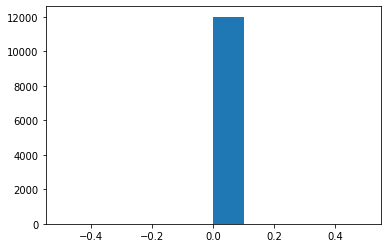

In [33]:
sampler_w = arnett.nested_fitting(ds, time_range=time_range, texpl_range=texpl_range, time_valid=time_valid, sampler='dynamic_nested')
plt.hist(sampler_w.pregen_logls)
sampler = sampler_w.sampler

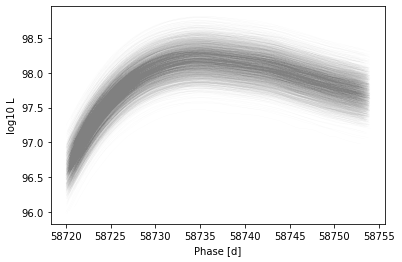

In [34]:
for i in range(min(3000, sampler_w.pregen_times.shape[0])):
    pregen_t = sampler_w.pregen_times[i,:]
    pregen_l = sampler_w.pregen_lums[i,:]
    x = table.Table({'t': pregen_t, 'l': pregen_l})
    x.sort('t')
    plt.plot(x['t'], x['l'], color='grey', alpha=0.1, lw=0.1)
plt.ylabel('log10 L')
plt.xlabel('Phase [d]')
plt.savefig('2022-02-15-arnett-plain-sn2019odp-sampled-lcs.png');

In [35]:
sampler.run_nested()#dlogz_init=0.5)
main_results = sampler.results

21604it [05:55, 60.69it/s, batch: 10 | bound: 454 | nc: 6 | ncall: 422134 | eff(%):  5.118 | loglstar: -9.701 < -0.053 < -0.490 | logz: -6.949 +/-  0.141 | stop:  0.925]          


In [36]:
sampler.run_nested(maxiter=1000)

0it [00:00, ?it/s]


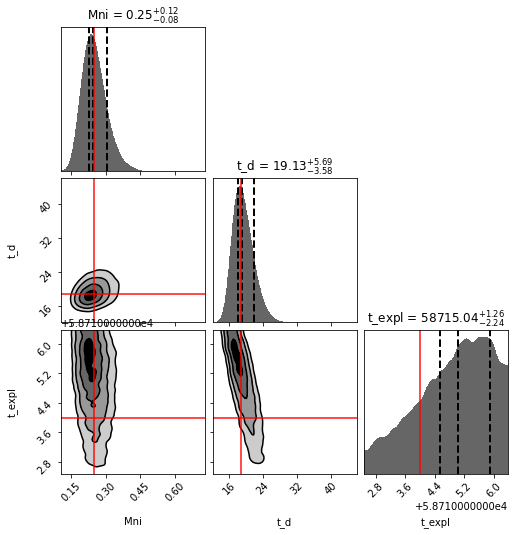

In [37]:
mej = 5.51 * u.Msun.to(u.g)
ekin = 6.56e51
x = 6/5
td_sheng = np.sqrt(0.07/13.8/(aconst.c.cgs.value)*np.sqrt(x*mej**3/ekin)) * u.s.to(u.d)
dyplot.cornerplot(sampler.results, labels=['Mni', 't_d', 't_expl'], show_titles=True, quantiles=[0.3413,0.5,0.8413], truths=[0.25,td_sheng,58714]);
plt.savefig('2022-02-15-arnett-plain-sn2019odp-corner.png');

In [10]:
results = sampler.results
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
trace = dyfunc.resample_equal(samples, weights)

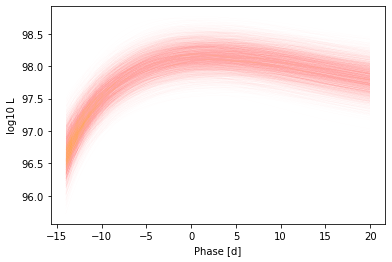

In [11]:
t_grid = np.linspace(ds.transient.prior_t0 - 14, ds.transient.prior_t0+20)
m = np.vectorize(arnett.luminosity_nico)
for i in range(min(3000, trace.shape[0])):
    p = trace[i*134 % trace.shape[0]]
    l = m(t_grid, *p)
    plt.plot(t_grid - ds.transient.prior_t0, l, color='orange', alpha=0.03, lw=0.1)
plt.ylabel('log10 L')
plt.xlabel('Phase [d]')
plt.savefig('2022-02-15-arnett-plain-sn2019odp-model-lcs.png');

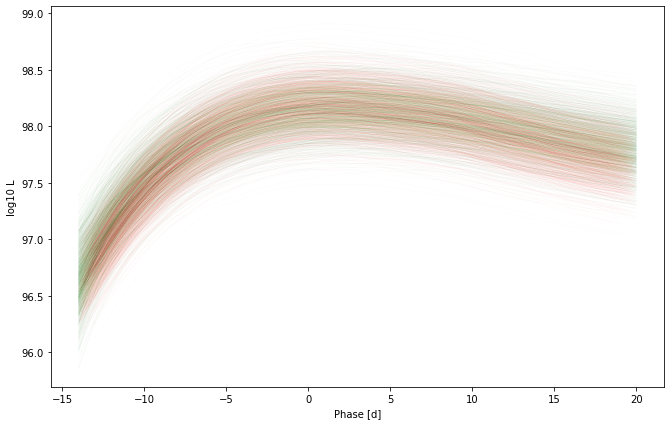

In [12]:
plt.figure(figsize=(11,7))
for i in range(min(1000, sampler_w.pregen_times.shape[0])):
    pregen_t = sampler_w.pregen_times[i,:] - ds.transient.prior_t0
    pregen_l = sampler_w.pregen_lums[i,:]
    x = table.Table({'t': pregen_t, 'l': pregen_l})
    x.sort('t')
    plt.plot(x['t'], x['l'], color='red', alpha=0.06, lw=0.2)

t_grid = np.linspace(ds.transient.prior_t0 - 14, ds.transient.prior_t0+20, 300)
m = np.vectorize(arnett.luminosity_nico)
for i in range(min(1000, trace.shape[0])):
    p = trace[i*134 % trace.shape[0]]
    l = m(t_grid, *p)
    plt.plot(t_grid - ds.transient.prior_t0, l, color='green', alpha=0.06, lw=0.2)

plt.ylabel('log10 L')
plt.xlabel('Phase [d]')
plt.savefig('2022-02-15-arnett-plain-sn2019odp-model-lcs-overlay.png');

t_d = 1.937597e+01 +- 2.410413e+00
M_ej [Khatami] = 9.217478e+00 +- 2.357027e+00
M_ej [Sheng] = 5.958247e+00 +- 1.523600e+00
M_ej [Tigerfit] = 2.766930e+00 +- 7.075393e-01
M_ej [Arnett82] = 5.958247e+00 +- 1.523600e+00


array([5.70109344, 5.09610615, 6.4358344 ])

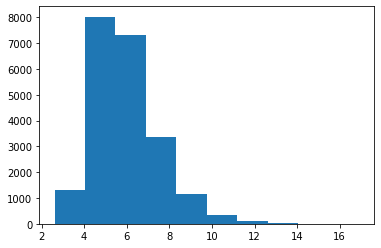

In [13]:
results = sampler.results
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
trace = dyfunc.resample_equal(samples, weights)

print('t_d = %e +- %e' % (np.mean(trace[:,1]), np.std(trace[:,1])))

t_d = trace[:,1] * u.day.to(u.s)
xi = np.pi**2 / 3  # Arnett
# xi = 1 # one-zone model
opacity = 0.07
c = aconst.c.cgs.value
v_ej = 10912 * u.km.to(u.cm)
m_ej = t_d**2 * 4 * np.pi / 3 * v_ej * c * xi / opacity * u.g.to(u.Msun)

print('M_ej [Khatami] = %e +- %e' % (np.mean(m_ej), np.std(m_ej)))

opacity = 0.07
sigma = 6/5
t_d = trace[:,1] * u.day.to(u.s)
v_m = 10912 * u.km.to(u.cm)
m_ej = v_m * t_d**2 * 13.8 * c / opacity / np.sqrt(2*sigma) * u.g.to(u.Msun)

print('M_ej [Sheng] = %e +- %e' % (np.mean(m_ej), np.std(m_ej)))

kappa = 0.07
kms2cms=1.e5
c=2.99792458e10
Msun=1.99e33
day=86400.

v_m = 10912
m_ej = ((3./10.)*(13.8*c/kappa)*v_m*kms2cms*(t_d)**2)/Msun

print('M_ej [Tigerfit] = %e +- %e' % (np.mean(m_ej), np.std(m_ej)))

kappa = 0.07
beta = 13.8

v_m = 10912 * u.km.to(u.cm) / np.sqrt(0.6)
m_ej = t_d**2 * beta * c * v_m / 2 / opacity * u.g.to(u.Msun)

print('M_ej [Arnett82] = %e +- %e' % (np.mean(m_ej), np.std(m_ej)))

plt.hist(m_ej);
np.percentile(m_ej, [50, 32, 68])

In [14]:
tmaxs = np.array([15, 17, 20, 23, 25, 27, 30, 33, 35, 37, 40, 50, 60])
results_tmax = []
for t_max in tmaxs:
    time_range_tmax = (ds.transient.prior_t0 - 14, ds.transient.prior_t0+t_max)
    sampler_tmax, _logl = arnett.nested_fitting(ds, time_range=time_range_tmax, texpl_range=texpl_range, time_valid=time_valid)
    sampler_tmax.run_nested()#dlogz_init=0.25)
    results_tmax.append(sampler_tmax.results)

100%|██████████| 12000/12000 [00:39<00:00, 305.84it/s]


ValueError: too many values to unpack (expected 2)

In [ ]:
for t_max, result in zip(tmaxs, results_tmax):
    samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    
    t_d = trace[:,1] * u.day.to(u.s)
    xi = np.pi**2 / 3  # Arnett
    # xi = 1 # one-zone model
    opacity = 0.07
    c = aconst.c.cgs.value
    v_ej = 10912 * u.km.to(u.cm)
    m_ej = t_d**2 * 4 * np.pi / 3 * v_ej * c * xi / opacity * u.g.to(u.Msun)
    plt.errorbar(t_max, np.nanmean(m_ej), yerr=np.nanstd(m_ej), marker='o')
plt.axhline(5.51, ls='--', color='grey')
plt.axhline(5.51-0.22, ls='--', alpha=0.5, color='grey')
plt.axhline(5.51+0.15, ls='--', alpha=0.5, color='grey');
plt.ylabel('Mej [Msol]')
plt.xlabel('t_max [d]');
plt.savefig('2022-02-15-arnett-plain-sn2019odp-tmax-mej.png')

In [ ]:
for t_max, result in zip(tmaxs, results_tmax):
    samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    t_d = trace[:,1]
    plt.errorbar(t_max, np.nanmean(t_d), yerr=np.nanstd(t_d), marker='o')
plt.axhline(18.3, ls='--', alpha=0.5, color='grey')
plt.axhline(19.5, ls='--', alpha=0.5, color='grey')
plt.ylabel('t_d [d]')
plt.xlabel('t_max [d]');
plt.savefig('2022-02-15-arnett-plain-sn2019odp-tmax-tdiff.png')

In [ ]:
for t_max, result in zip(tmaxs, results_tmax):
    samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    m_ni = trace[:,0]
    plt.errorbar(t_max, np.nanmean(m_ni), yerr=np.nanstd(m_ni), marker='o')
plt.axhline(0.25, ls='--', alpha=0.5, color='grey')
plt.ylabel('Mni [Msol]')
plt.xlabel('t_max [d]');
plt.savefig('2022-02-15-arnett-plain-sn2019odp-tmax-mni.png')

In [ ]:
for t_max, result in zip(tmaxs, results_tmax):
    samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    texpl = trace[:,2]
    plt.errorbar(t_max, np.nanmean(texpl), yerr=np.nanstd(texpl), marker='o')
plt.axhline(58714.5, ls='--', alpha=0.5, color='grey')
plt.ylabel('texpl [d]')
plt.xlabel('t_max [d]');
plt.savefig('2022-02-15-arnett-plain-sn2019odp-tmax-texpl.png')

In [ ]:
for t_max, result in zip(tmaxs, results_tmax):
    logz = result.logz[-1]
    plt.scatter(t_max, logz, marker='o')
plt.ylabel('log z (Evidence)')
plt.xlabel('t_max [d]');
plt.savefig('2022-02-15-arnett-plain-sn2019odp-tmax-logz.png')

In [ ]:
tmins = np.array([-16.5, -16, -15, -14, -13, -11, -9, -7, -5])
results_tmin = []
for t_min in tmins:
    time_range_tmax = (ds.transient.prior_t0 + t_min, ds.transient.prior_t0+33+t_min/2)
    sampler_tmin, _logl = arnett.nested_fitting(ds, time_range=time_range_tmax, texpl_range=texpl_range, time_valid=time_valid)
    sampler_tmin.run_nested()#dlogz_init=0.25)
    results_tmin.append(sampler_tmin.results)

In [ ]:
for t_min, result in zip(tmins, results_tmin):
    logz = result.logz[-1]
    plt.scatter(t_min, logz, marker='o')
plt.ylabel('log z (Evidence)')
plt.xlabel('t_min [d]');

In [ ]:
for t_min, result in zip(tmins, results_tmin):
    samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    texpl = trace[:,2]
    plt.errorbar(t_min, np.nanmean(texpl), yerr=np.nanstd(texpl), marker='o')
plt.axhline(58714.5, ls='--', alpha=0.5, color='grey')
plt.ylabel('texpl [d]')
plt.xlabel('t_min [d]');

In [ ]:
for t_min, result in zip(tmins, results_tmin):
    samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    t_d = trace[:,1]
    plt.errorbar(t_min, np.nanmean(t_d), yerr=np.nanstd(t_d), marker='o')
plt.axhline(18.3, ls='--', alpha=0.5, color='grey')
plt.axhline(19.5, ls='--', alpha=0.5, color='grey')
plt.ylabel('t_d [d]')
plt.xlabel('t_min [d]');

In [27]:
texpl_errs = np.array([0.01, 0.1, 1.0, 2.0, 4.0])
results = []
t_max = 20
for texpl_err in texpl_errs:
    texpl_range = (58714.5 - texpl_err/2, 58714.5+texpl_err/2)
    time_range = (ds.transient.prior_t0 - 14, ds.transient.prior_t0+t_max)
    sampler_w = arnett.nested_fitting(ds, time_range=time_range, texpl_range=texpl_range, time_valid=time_valid, sampler='dynamic_nested')
    sampler = sampler_w.sampler
    sampler.run_nested(dlogz_init=0.1)#dlogz_init=0.25)
    results.append(sampler.results)

100%|██████████| 12000/12000 [00:38<00:00, 307.81it/s]
18368it [27:40,  1.62s/it, batch: 9 | bound: 3260 | nc: 370 | ncall: 2847241 | eff(%):  0.644 | loglstar: -6.785 < -0.433 < -0.283 | logz: -6.813 +/-  0.142 | stop:  1.166]      Traceback (most recent call last):
  File "/home/welterde/.local/lib/python3.8/site-packages/dynesty/dynesty.py", line 982, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "../lib/snelib19odp/noisy_likelihood.py", line 47, in likelihood_t_mjd
    model = 2.5*modfunc(t_grid, *x)
  File "/home/welterde/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py", line 2108, in __call__
    return self._vectorize_call(func=func, args=vargs)
  File "/home/welterde/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py", line 2192, in _vectorize_call
    outputs = ufunc(*inputs)
  File "../lib/snelib19odp/analysis/arnett.py", line 37, in luminosity_nico
    pre_factor = 2/td**2 * np.exp(-t**2 / td**2)
KeyboardInterrupt
18368i

Exception while calling loglikelihood function:
  params: [2.03113118e-01 1.78676417e+01 5.87144966e+04]
  args: []
  kwargs: {'pregen_times': array([[58750.70448313, 58737.11073843, 58741.85034311, ...,
        58733.40675857, 58724.03322137, 58752.62434475],
       [58721.81713082, 58748.41032978, 58743.46917479, ...,
        58721.96306849, 58740.15182876, 58740.24396735],
       [58742.43090511, 58737.56706168, 58737.07013526, ...,
        58722.15177495, 58747.79799014, 58746.59955032],
       ...,
       [58741.72270623, 58748.53822769, 58742.88365917, ...,
        58734.37670647, 58749.43445592, 58743.79067801],
       [58725.66164668, 58737.54770559, 58751.46409271, ...,
        58737.40382854, 58726.59879291, 58753.85543938],
       [58733.80528573, 58743.22022105, 58739.26613575, ...,
        58729.77568589, 58746.10597965, 58750.77602245]]), 'pregen_lums': array([[97.86380677, 98.23056329, 98.16699848, ..., 98.24364569,
        97.50134507, 97.79819486],
       [97.17613132,

KeyboardInterrupt: 

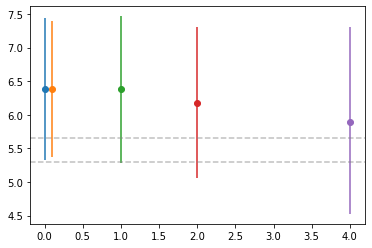

In [25]:
for texpl_err, result in zip(texpl_errs, results):
    samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    
    t_d = trace[:,1] * u.day.to(u.s)
    xi = np.pi**2 / 3  # Arnett
    # xi = 1 # one-zone model
    opacity = 0.07
    #c = aconst.c.cgs.value
    #v_ej = 10912 * u.km.to(u.cm) / 0.6
    #m_ej = t_d**2 * 4 * np.pi / 3 * v_ej * c * xi / opacity * u.g.to(u.Msun)
    kappa = 0.07
    beta = 13.8

    v_m = 10912 * u.km.to(u.cm) / np.sqrt(0.6)
    m_ej = t_d**2 * beta * c * v_m / 2 / opacity * u.g.to(u.Msun)
    dm_p, dm_n = np.percentile(m_ej, [84.13, 15.87])
    m_mean = np.nanmean(m_ej)
    #plt.errorbar(texpl_err, np.nanmean(m_ej), yerr=np.nanstd(m_ej), marker='o')
    plt.errorbar(texpl_err, m_mean, yerr=([dm_p-m_mean], [m_mean-dm_n]), marker='o')
#plt.axhline(5.51, ls='--', color='grey')
plt.axhline(5.51-0.22, ls='--', alpha=0.5, color='grey')
plt.axhline(5.51+0.15, ls='--', alpha=0.5, color='grey');

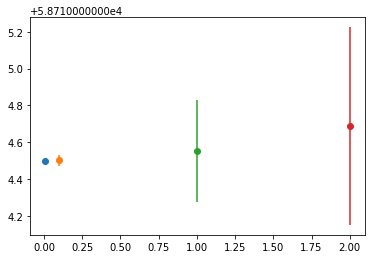

In [21]:
for texpl_err, result in zip(texpl_errs, results):
    samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    texpl = trace[:,2]
    plt.errorbar(texpl_err, np.nanmean(texpl), yerr=np.nanstd(texpl), marker='o')


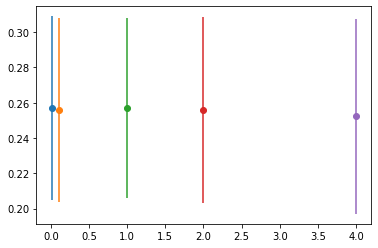

In [26]:
for texpl_err, result in zip(texpl_errs, results):
    samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    mni = trace[:,0]
    plt.errorbar(texpl_err, np.nanmean(mni), yerr=np.nanstd(mni), marker='o')

100%|██████████| 12000/12000 [00:39<00:00, 303.32it/s]
3637it [00:22, 161.49it/s, +500 | bound: 36 | nc: 1 | ncall: 44725 | eff(%):  9.250 | loglstar:   -inf < -0.416 <    inf | logz: -6.913 +/-  0.150 | dlogz:  0.001 >  0.509]


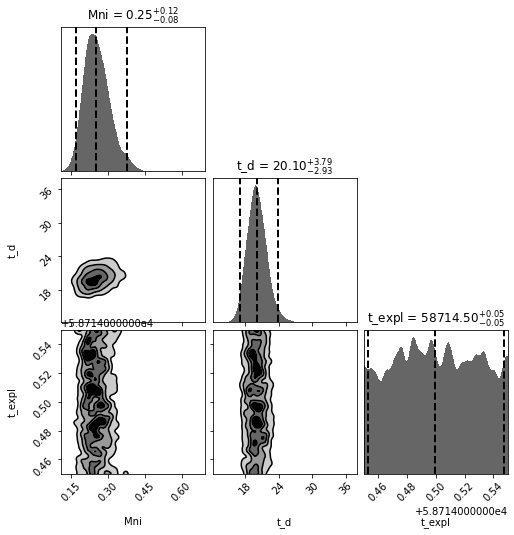

In [23]:
texpl_err = 0.1
t_max=20
texpl_range = (58714.5 - texpl_err/2, 58714.5+texpl_err/2)
time_range = (ds.transient.prior_t0 - 14, ds.transient.prior_t0+t_max)
sampler_w = arnett.nested_fitting(ds, time_range=time_range, texpl_range=texpl_range, time_valid=time_valid)
sampler = sampler_w.sampler
sampler.run_nested()
dyplot.cornerplot(sampler.results, labels=['Mni', 't_d', 't_expl'], show_titles=True);

In [ ]:
t_grid = ds.transient.prior_t0 + np.linspace(-16, 50)
bolometric_method = 'lyman'
for i in range(500):
    lc = ds.sample_abs_lc(method=bolometric_method, t_grid=t_grid, tweaks=['correlated-error'])
    lums = np.log(utils.convert_luminosity(lc))
    #plt.plot(t_grid, lums, alpha=0.02, color='blue')

samples, weights = main_results.samples, np.exp(main_results.logwt - main_results.logz[-1])
trace = dyfunc.resample_equal(samples, weights)
modfunc = np.vectorize(arnett.luminosity_nico)
for i in range(500):
    x = trace[i*10 % trace.shape[0]]
    lums = modfunc(t_grid, *x)
    plt.plot(t_grid, lums, alpha=0.02, color='orange')

In [ ]:
t_grid = ds.transient.prior_t0 + np.linspace(-14, 20)
bolometric_method = 'lyman'
for i in range(500):
    lc = ds.sample_abs_lc(method=bolometric_method, t_grid=t_grid, tweaks=['correlated-error'])
    lums = np.log(utils.convert_luminosity(lc))
    #plt.plot(t_grid, lums - lums[13], alpha=0.02, color='blue')
    plt.plot(t_grid, lums - np.percentile(lums, 95), alpha=0.02, color='blue')

samples, weights = main_results.samples, np.exp(main_results.logwt - main_results.logz[-1])
trace = dyfunc.resample_equal(samples, weights)
modfunc = np.vectorize(arnett.luminosity_nico)
for i in range(500):
    x = trace[i*10 % trace.shape[0]]
    #x[2] = 58714.5
    lums = modfunc(t_grid, *x)
    #plt.plot(t_grid, lums - lums[13], alpha=0.02, color='orange')
    plt.plot(t_grid, lums - np.percentile(lums, 95), alpha=0.02, color='orange')

In [ ]:
dyplot.cornerbound(main_results, it=4999)

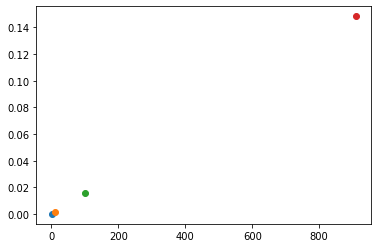

In [45]:
for v_m_err in [1, 10, 100, 0.91e3]:
    vm = np.random.normal(10.10e3, v_m_err, size=1000) * u.km.to(u.cm)
    td = 10.55 * u.d.to(u.s)
    x = 6/5
    mej = vm*td**2 * 13.8 * (aconst.c.cgs.value)/0.07/np.sqrt(2*x) * u.g.to(u.Msun)
    plt.scatter(v_m_err, np.nanstd(mej))

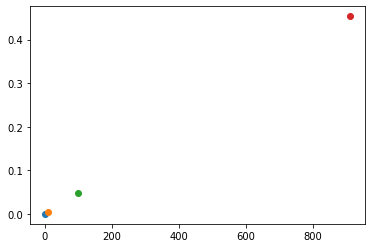

In [44]:
for v_m_err in [1, 10, 100, 0.91e3]:
    vm = np.random.normal(10.10e3, v_m_err, size=1000) * u.km.to(u.cm)
    td = 10.55 * u.d.to(u.s)
    x = 6/5
    ekin = vm**3 * td**2 *13.8 * (aconst.c.cgs.value) / 0.07 / np.sqrt(8*x) / 1e51
    plt.scatter(v_m_err, np.nanstd(ekin))